In [ ]:
#default_exp diagrams

In [ ]:
# ! conda install -c conda-forge graphviz python-graphviz 

In [ ]:
#export
from typing import List, Optional, Tuple, Dict
from collections import defaultdict

from hopeit.dataobjects import dataobject, dataclass
from hopeit.app.config import AppConfig, EventType
from hopeit.testing.apps import config
from graphviz import Digraph


In [ ]:
#export
@dataobject
@dataclass
class Port:
    id: str
    label: str

@dataobject
@dataclass
class Node:
    id: str
    label: str
    inputs: List[Port]
    outputs: List[Port]
    shape: str = "box"
    color: str = "#AACCAA"
    fontsize: str = "14"
        
    def __hash__(self):
        return hash(self.id)
    
    def __eq__(self, other):
        return self.id == other.id
    
@dataobject
@dataclass
class Edge:
    id: str
    label: str
    source: Node
    dest: Node

@dataobject
@dataclass
class Graph:
    nodes: List[Node]
    edges: List[Edge]


In [ ]:
#export
def _extract_nodes(config: AppConfig, streams: bool = True) -> List[Node]:
    nodes = []
    for event_name, event_info in config.events.items():
        
        inputs = []
        if event_info.type in (EventType.GET, EventType.POST):
            port = Port(id=f"{event_name}.{event_info.type.value}", label=event_info.type.value)
            inputs.append(port)
            nodes.append(Node(
                id=port.id, 
                label=port.label, 
                inputs=[], 
                outputs=[port],
                shape="point"
            ))
        elif event_info.type == (EventType.STREAM):
            inputs.append(Port(id=f">{event_info.read_stream.name}", label=event_info.read_stream.name))
        
        outputs = []
        if event_info.write_stream:
            if streams:
                outputs.append(Port(id=event_info.write_stream.name, label=event_info.write_stream.name))
                stream_in = Port(id=event_info.write_stream.name, label=event_info.write_stream.name)
                stream_out = Port(id=f">{event_info.write_stream.name}", label=event_info.write_stream.name)
                nodes.append(Node(
                    id=stream_in.id,
                    label=f"\u2192 {stream_in.label} \u2192",
                    inputs=[stream_in],
                    outputs=[stream_out],
                    shape='Mrecord',
                    color='#AAAAFF',
                    fontsize="10"
                ))
            else:
                outputs.append(Port(id=f">{event_info.write_stream.name}", label=event_info.write_stream.name))
        
        nodes.append(Node(
            id=event_name,
            label=event_name,
            inputs=inputs,
            outputs=outputs
        ))
    return nodes

PortMap = Dict[str, List[Node]]

def _index_node_input_outputs(nodes: List[Node]) -> Tuple[PortMap, PortMap]:
    inputs, outputs = defaultdict(set), defaultdict(set)
    for node in nodes:
        for port in node.inputs:
            inputs[port.id].add(node)
        for port in node.outputs:
            outputs[port.id].add(node)
    return inputs, outputs

def _get_edges(port: str, from_nodes: List[Node], to_nodes: List[Node]):
    return [
        Edge(id=port, label=port, source=from_node, dest=to_node)
        for from_node in from_nodes for to_node in to_nodes
    ]

def _extract_edges(inputs: PortMap, outputs: PortMap) -> List[Edge]:
    edges = []
    for port, from_nodes in outputs.items():
        to_nodes = inputs.get(port, [])
        edges.extend(_get_edges(port, from_nodes, to_nodes))
    return edges
            
    


In [ ]:
#export
def draw_graph(config: AppConfig, show_streams: bool = True):
    nodes = _extract_nodes(config, show_streams)
    inputs, outputs = _index_node_input_outputs(nodes)
    edges = _extract_edges(inputs, outputs)
    
    dot = Digraph(comment='Graph')
    
    for node in nodes:
        dot.node(node.id, node.label, shape=node.shape, style='filled', fillcolor=node.color, fontsize=node.fontsize)
        
    for edge in edges:
        dot.edge(edge.source.id, edge.dest.id, "")
        
    return dot
    

In [ ]:
!nbdev_build_lib

Converted 00_jobs.ipynb.
Converted 01_create-sample-data.ipynb.
Converted 02_preprocess.ipynb.
Converted 03_feature-calc.ipynb.
Converted 04_training-data.ipynb.
Converted 05_train-model.ipynb.
Converted 06_submit-training-pipeline.ipynb.
Converted 07_prepare-db.ipynb.
Converted 08_predict.ipynb.
Converted 09_find-orders.ipynb.
Converted 20_diagramas.ipynb.
Converted 99_tools.ipynb.
Converted index.ipynb.


### Example diagramas from config

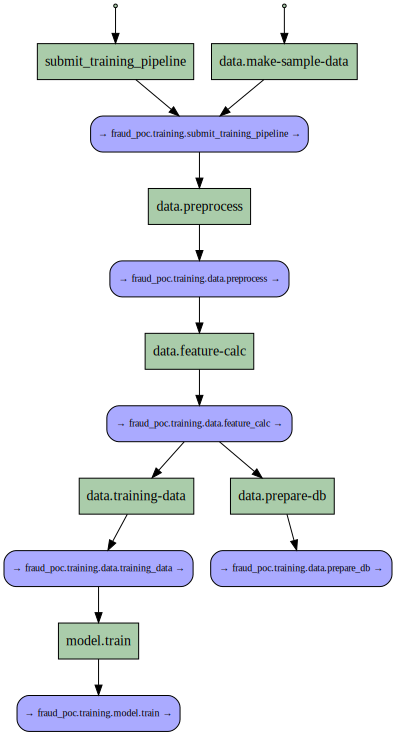

In [ ]:
from hopeit.testing.apps import config
from fraud_poc.diagrams import draw_graph

training_config = config('config/training-pipeline.json')
dot = draw_graph(training_config, show_streams=True)
dot

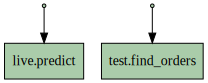

In [ ]:
from hopeit.testing.apps import config
from fraud_poc.diagrams import draw_graph

service_config = config('config/fraud-service.json')
dot = draw_graph(service_config)
dot